In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.FireFramework import * # importieren des Frameworks
from PIL import Image

import utility.animation_utility as anim
import utility.io_utility as io

In [2]:
def drawImage(field, index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (100,100))], axis = 2))
    plt.show()

In [3]:
def loadImage(path, size):
    img_ = Image.open(path).resize(size, Image.BICUBIC)
    img = np.array(img_) / 255
    img_.close()
    return img

In [4]:
def dot(t1,t2):
    return t1[0] * t2[0] + t1[1] * t2[1]

In [5]:
# Liste der pro Zelle zu speichernden Werte
params = ["fuel", "fire", "windx", "windy", "height", "burned", "flammability"]

# Relativvektoren der zu betrachtenen Nachbarn (Kreis mit Radius #)
radius = 1

relative_neighbours = []
for x in range(radius * 2 +1):
    for y in range(radius*2 +1):
        xcord = x - radius
        ycord = y - radius
        r = xcord**2 + ycord**2
        
        if r <= radius**2 and r != 0:
            relative_neighbours.append((xcord,ycord))

In [6]:
def transition(cellState, neighbourStates, returnState):
    
    #Parameter der Nachbarn:
    slope = []
    rel_wind = []
    neighbour_fire = []
    distance = []

    #Vorbereitung der Werte der Nachbarn
    for n in neighbourStates:
        
        slope_ = np.tanh(n.getParam("height") - cellState.getParam("height"))
        fire_ = n.getParam("fire")
        distance_ = np.sqrt(dot(n.getRelativeVector(), n.getRelativeVector()))
        wind = (n.getParam("windx"), n.getParam("windy"))
        rel_wind_ = np.tanh(dot(wind, n.getRelativeVector()) / distance_)
        
        slope.append(slope_)
        neighbour_fire.append(fire_)
        distance.append(distance_)
        rel_wind.append(rel_wind_)  

    #Konvertieren zu numpy arrays
    slope = np.array(slope)
    rel_wind = np.array(rel_wind)
    neighbour_fire = np.array(neighbour_fire)
    distance = np.array(distance)

    #Wahrscheinlichkeiten berechnen

    slope_coeff = - np.sum(neighbour_fire * slope / distance)
    wind_coeff = - np.sum(neighbour_fire * rel_wind / distance)
    
    p_burn = 1/8 * np.sum(neighbour_fire / distance) + 0.1 * slope_coeff + 0.1 * wind_coeff
    p_burn *= cellState.getParam("flammability")
    
    p_stop = (1 - cellState.getParam("fuel")) ** 8  #Erlöschen bei wenig Brennwert

    
    #Wahrscheinlichkeiten umsetzen
    
    
    if p_burn >= np.random.uniform():
        returnState.setParam("fire", 1)
    
    if cellState.getParam("fire") == 1:
        if p_stop >= np.random.uniform():
            returnState.setParam("fire", 0)
            returnState.setParam("burned", 1)
    


        
    returnState.addToParam("fuel", -0.05*cellState.getParam("fire")) # Verringerung des Brennwerts
    if returnState.getParam("fuel") < 0:
        returnState.setParam("fuel", 0)
    returnState.addToParam("flammability", -0.05*cellState.getParam("fire"))
    if returnState.getParam("flammability") < 0:
        returnState.setParam("flammability", 0)

## Initial Fields

In [7]:
def vari_Evan():
    fuelmap = loadImage("data/fuelmap1.jpg", (20,20))
    heightmap = loadImage("data/heightmap.jpg", (20,20))

    def initial_field(row, col):
        fuel = (1 - fuelmap[row,col,2])**4
        burn = 0
        if row == 10 and col == 10: burn = 1

        height = heightmap[row,col,0]
        windx = 5
        windy = 0

        return [fuel, burn, windx, windy, height] # Hier der Anfangswert-return


In [8]:
def var_fuel(size, N, start, stop, incr):
    def initial_field(row, col):
        fuel = pfuel
        flammability = 0.99
        burn = 0
        burned = 0
        if row == size/2-1 and col == size/2-1: burn = 1
    
        height = 0
        windx = 0
        windy = 0
    
        return [fuel, burn, windx, windy, height, burned, flammability] # Hier der Anfangswert-return
    
    
    result = []

    pfuel = start
    while pfuel <= stop:
        
        # Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
        g = Grid(size, size, params, relative_neighbours, transition, initial_field)
        
        # Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
        result.append(g.runModel(N))
        
        pfuel = pfuel + incr
     
    return result

In [9]:
def var_flammability(size, N, start, stop, incr):
    def initial_field(row, col):
        fuel = 0.99
        flammability = pflammability
        burn = 0
        burned = 0
        if row == size/2-1 and col == size/2-1: burn = 1
    
        height = 0
        windx = 0
        windy = 0
    
        return [fuel, burn, windx, windy, height, burned, flammability] # Hier der Anfangswert-return
    
    
    result = []

    pflammability = start
    while pflammability <= stop:
        
        # Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
        g = Grid(size, size, params, relative_neighbours, transition, initial_field)
        
        # Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
        result.append(g.runModel(N))
        
        pflammability = pflammability + incr
     
    return result

In [10]:
def var_windx(size, N, start, stop, incr):
    def initial_field(row, col):
        fuel = 0.99
        flammability = 0.99
        burn = 0
        burned = 0
        if row == size/2-1 and col == size/2-1: burn = 1
    
        height = 0
        windx = pwindx
        windy = 0
    
        return [fuel, burn, windx, windy, height, burned, flammability] # Hier der Anfangswert-return
    
    
    result = []

    pwindx = start
    while pwindx <= stop:
        
        # Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
        g = Grid(size, size, params, relative_neighbours, transition, initial_field)
        
        # Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
        result.append(g.runModel(N))
        
        pwindx = pwindx + incr
    
    return result

In [11]:
def var_windy(size, N, start, stop, incr):
    def initial_field(row, col):
        fuel = 0.99
        flammibility = 0.99
        burn = 0
        burned = 0
        if row == size/2-1 and col == size/2-1: burn = 1
    
        height = 0
        windx = 0
        windy = pwindy
    
        return [fuel, burn, windx, windy, height, burned, flammability] # Hier der Anfangswert-return
    
    
    result = []

    pwindy = start
    while pwindy <= stop:
        
        # Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
        g = Grid(size, size, params, relative_neighbours, transition, initial_field)
        
        # Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
        result.append(g.runModel(N))
        
        pwindy = pwindy + incr
        
    return result

In [12]:
def var_slope(size, N, start, stop, incr):
    def initial_field(row, col):
        fuel = 0.99
        flammability = 0.99
        burn = 0
        burned = 0
        if row == size/2-1 and col == size/2-1: burn = 1
    
        height = slope*row
        
        
        windx = 0
        windy = 0
    
        return [fuel, burn, windx, windy, height, burned, flammability] # Hier der Anfangswert-return
    
    
    result = []

    slope = start
    while slope <= stop:
        
        # Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
        g = Grid(size, size, params, relative_neighbours, transition, initial_field)
        
        # Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
        result.append(g.runModel(N))
        
        slope = slope + incr
        
    return result

### Modell auswerten

In [13]:
# Nimmt ein numpy-array an welches zb. durch g.runModel() erzeugt wird.
# Zeichnet das Feld auf bekannte Weise unter angabe des zeitindex.
def drawImage(field,index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (field.shape[1], field.shape[2]))], axis = 2))

In [14]:
# Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
#N = 10
#result = g.runModel(N)

In [15]:
# save data:
path = "data/result_output_vari_r2"

In [16]:
io.write(var_fuel(50, 50, 0.9, 1, 0.2), path)

2%
12%
22%
32%
42%
52%
62%
72%
82%
92%


In [17]:
# Nimmt ein numpy-array an welches zb. durch g.runModel() erzeugt wird.
# Zeichnet das Feld auf bekannte Weise unter angabe des zeitindex.
def drawImage(field,index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (field.shape[1], field.shape[2]))], axis = 2))

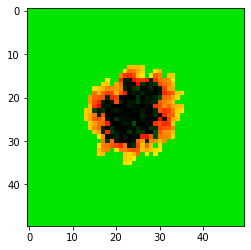

In [18]:
anim.animate(io.read(path)[0], path)